# Chapter6 The Method of Godunov for Non–linear Systems

## expansion to 3 dimension

In [19]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pyvista as pv
import random

pv.set_jupyter_backend("static")   # 가장 안정적

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Using device: cuda
CUDA device: NVIDIA GeForce GTX 1660 SUPER


In [20]:
#Constant parameters
NUM_CELLS_X = 100
NUM_CELLS_Y = 100
NUM_CELLS_Z = 100

X_DOMAIN = [0, 1]
Y_DOMAIN = [0, 1]
Z_DOMAIN = [0, 1]
T_DOMAIN = [0, 0.5]
DX = (X_DOMAIN[1] - X_DOMAIN[0]) / NUM_CELLS_X
DY = (Y_DOMAIN[1] - Y_DOMAIN[0]) / NUM_CELLS_Y
DZ = (Z_DOMAIN[1] - Z_DOMAIN[0]) / NUM_CELLS_Z

CFL_COEFFICIENT = 0.8
GAMMA = 1.4
TOL = 1e-6

DIAMETER = 0.2

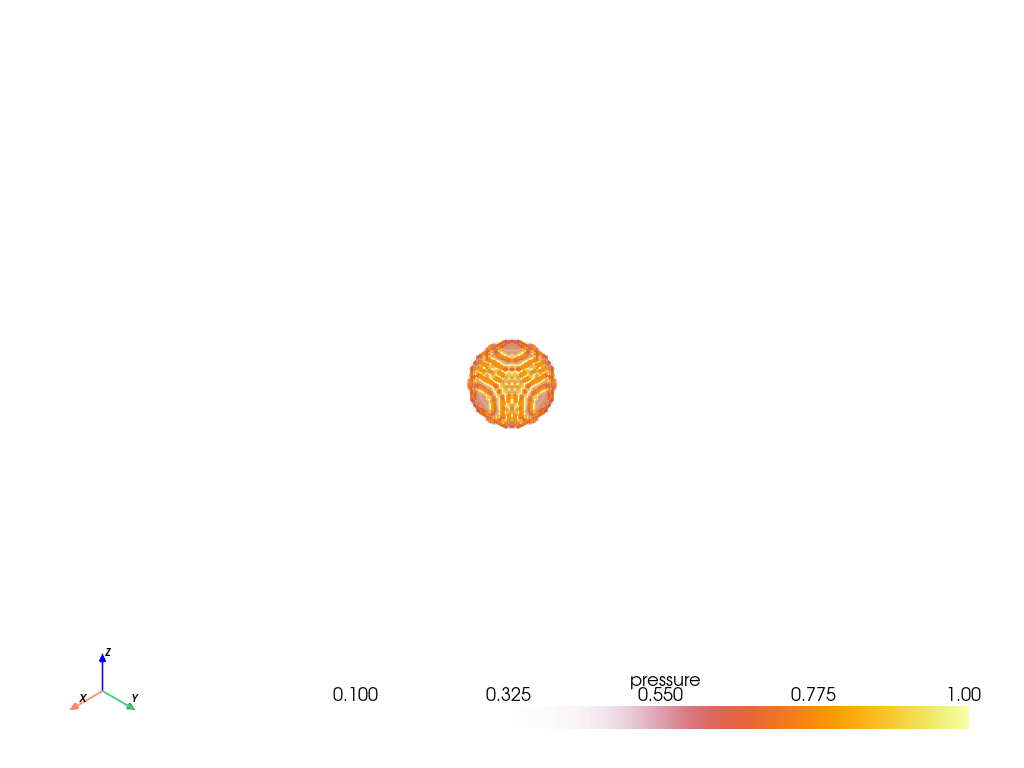

In [21]:
#Initial conditions - Explosion scenario
# +2 for cell boundary (ghost cells)
# Shape: (Nz + 2, Ny + 2, Nx + 2, 5) - [rho, u, v, w, p]
CELL = torch.zeros((NUM_CELLS_Z + 2, NUM_CELLS_Y + 2, NUM_CELLS_X + 2, 5), device=device)

# 중심 좌표 (도메인 중앙)
center_x = (X_DOMAIN[0] + X_DOMAIN[1]) / 2
center_y = (Y_DOMAIN[0] + Y_DOMAIN[1]) / 2
center_z = (Z_DOMAIN[0] + Z_DOMAIN[1]) / 2
radius = DIAMETER / 2  # 반경

# 각 셀의 중심 좌표 계산 (ghost cell 제외한 실제 셀만)
x_coords = torch.linspace(X_DOMAIN[0] + DX/2, X_DOMAIN[1] - DX/2, NUM_CELLS_X, device=device)
y_coords = torch.linspace(Y_DOMAIN[0] + DY/2, Y_DOMAIN[1] - DY/2, NUM_CELLS_Y, device=device)
z_coords = torch.linspace(Z_DOMAIN[0] + DZ/2, Z_DOMAIN[1] - DZ/2, NUM_CELLS_Z, device=device)
X, Y, Z = torch.meshgrid(x_coords, y_coords, z_coords, indexing='xy')  # (Ny, Nx)

# 중심으로부터의 거리 계산
distances = torch.sqrt((X - center_x)**2 + (Y - center_y)**2 + (Z - center_z)**2)

# 폭발 영역 (반경 내부): 고압, 고밀도
explosion_mask = distances < radius

# 기본값 설정 (외부 영역) - ghost cell 포함 전체
CELL[:, :, :, 0] = 0.125  # rho (low density)
CELL[:, :, :, 1] = 0.0    # u
CELL[:, :, :, 2] = 0.0    # v
CELL[:, :, :, 3] = 0.0    # w
CELL[:, :, :, 4] = 0.1    # p (low pressure)

# 폭발 영역 설정 (고압, 고밀도) - 실제 셀만 (ghost cell 제외)
CELL[1:-1, 1:-1, 1:-1, 0][explosion_mask] = 1.0   # rho (high density)
CELL[1:-1, 1:-1, 1:-1, 1][explosion_mask] = 0.0    # u
CELL[1:-1, 1:-1, 1:-1, 2][explosion_mask] = 0.0    # v
CELL[1:-1, 1:-1, 1:-1, 3][explosion_mask] = 0.0    # w
CELL[1:-1, 1:-1, 1:-1, 4][explosion_mask] = 1.0    # p (high pressure)

# Plot initial conditions as 3D scatter (subsampled)
rho_values = CELL[1:-1, 1:-1, 1:-1, 0].cpu().numpy()
u_values = CELL[1:-1, 1:-1, 1:-1, 1].cpu().numpy()
v_values = CELL[1:-1, 1:-1, 1:-1, 2].cpu().numpy()
w_values = CELL[1:-1, 1:-1, 1:-1, 3].cpu().numpy()
p_values = CELL[1:-1, 1:-1, 1:-1, 4].cpu().numpy()

grid = pv.ImageData() 

# VTK 규칙: cell data → dimensions = cell + 1
grid.dimensions = (NUM_CELLS_X + 1, NUM_CELLS_Y + 1, NUM_CELLS_Z + 1)
grid.spacing = (DX, DY, DZ)   # 격자 간격 
grid.origin = (X_DOMAIN[0], Y_DOMAIN[0], Z_DOMAIN[0])

grid.cell_data["density"]  = rho_values.flatten(order="F")
grid.cell_data["pressure"] = p_values.flatten(order="F")

velocity = np.stack(
    [u_values, v_values, w_values],
    axis=-1
)

grid.cell_data["velocity"] = velocity.reshape(-1, 3, order="F")

plotter = pv.Plotter()
plotter.add_volume(
    grid,
    scalars="pressure",
    cmap="inferno",
    opacity="sigmoid"
)
plotter.add_axes()
plotter.show()



In [22]:
#vectorized solution of local_riemann_problem

#local reimann problem에서 characteristic wave의 경계에서의 유속 변화량 f를 구함. + vectorized version
def compute_f_and_df(p, W_L, W_R):
    """
    W_L, W_R: (..., 4) - [rho, u, v, p] primitive variables
    p: (...,) - pressure guess
    """
    left_rho = W_L[..., 0]
    left_p = W_L[..., 4]
    right_rho = W_R[..., 0]
    right_p = W_R[..., 4]
    
    Al = 2 / (GAMMA + 1) / left_rho
    Ar = 2 / (GAMMA + 1) / right_rho
    Bl = (GAMMA - 1) / (GAMMA + 1) * left_p
    Br = (GAMMA - 1) / (GAMMA + 1) * right_p
    al = torch.sqrt(GAMMA * left_p / left_rho)
    ar = torch.sqrt(GAMMA * right_p / right_rho)
    
    left_shock_cell = p > left_p
    right_shock_cell = p > right_p

    #left rarefaction wave
    fl = 2 * al / (GAMMA - 1) * ((p/left_p)**((GAMMA - 1)/(2 * GAMMA)) - 1)
    d_fl = 1 / left_rho / al * (p/left_p)**(-(GAMMA + 1)/(2 * GAMMA))
  
    #overide left shock wave
    fl[left_shock_cell] = ((p - left_p) * torch.sqrt(Al / (p + Bl)))[left_shock_cell]
    d_fl[left_shock_cell] = (torch.sqrt(Al / (Bl + p)) * (1 - 0.5 * (p - left_p) / (Bl + p)))[left_shock_cell]


    #right rarefaction wave
    fr = 2 * ar / (GAMMA - 1) * ((p/right_p)**((GAMMA - 1)/(2 * GAMMA)) - 1)
    d_fr = 1 / right_rho / ar * (p/right_p)**(-(GAMMA + 1)/(2 * GAMMA))
    
    #overide right shock wave
    fr[right_shock_cell] = ((p - right_p)* torch.sqrt(Ar / (p + Br)))[right_shock_cell]
    d_fr[right_shock_cell] = (torch.sqrt(Ar / (Br + p)) * (1 - 0.5 * (p - right_p) / (Br + p)))[right_shock_cell]

    return fl, d_fl, fr, d_fr

#vectorized version of solve_riemann_star_state
def solve_riemann_star_state(W_L, W_R, normal='x'):
    """
    Get the exact Riemann solution for the Euler equations.
    Newton-Raphson iterative procedure

    p(k)= p(k-1)- f(p(k-1)) / f'(p(k-1))

    W_L, W_R: (..., 4) - [rho, u, v, p] primitive variables
    normal: 'x' or 'y' - direction of the Riemann problem
    
    return value: p*, u* (or v*), rho*l, rho*r
    """
    # Extract variables from state
    left_rho = W_L[..., 0]
    left_p = W_L[..., 4]
    right_rho = W_R[..., 0]
    right_p = W_R[..., 4]
    
    # Select velocity component based on normal direction
    if normal == 'x':
        left_u = W_L[..., 1]  # u component
        right_u = W_R[..., 1]
    elif normal == 'y':
        left_u = W_L[..., 2]  # v component
        right_u = W_R[..., 2]
    elif normal == 'z':
        left_u = W_L[..., 3]  # w component
        right_u = W_R[..., 3]
    else:
        raise ValueError("normal must be 'x' or 'y' or 'z'")

    # Initial guess for the pressure
    # Should be optimaized using Two–Rarefaction approximation, primitive variables, Two–Shock approximation.
    p = 0.5 * (left_p + right_p)
    count = 0
    while(True):
        count += 1
        prev_p = p
        fl, d_fl, fr, d_fr = compute_f_and_df(p, W_L, W_R)

        f = fl + fr  + right_u - left_u
        df = d_fl + d_fr

        p = p - f / df
        #음압 방지.
        p = torch.clamp(p, min=torch.tensor(1e-12, device=p.device))
        #모든 셀에서 충족하면 종료.
        tol_tensor = torch.tensor(TOL, device=p.device)
        if(torch.all(2 * abs(p - prev_p) < tol_tensor * (p + prev_p)) or count > 1000):
            break
    
    fl, d_fl, fr, d_fr = compute_f_and_df(p, W_L, W_R)
    u = 0.5 * (left_u + right_u + fr - fl)

    left_shock_cell = p > left_p
    right_shock_cell = p > right_p

    rho_l_star = left_rho * (p / left_p) ** (1 / GAMMA)
    rho_l_star[left_shock_cell] = (left_rho * (GAMMA * (p + left_p) - left_p + p) /
                                  (GAMMA * (p + left_p) - p + left_p))[left_shock_cell]

    rho_r_star = right_rho * (p / right_p) ** (1 / GAMMA)
    rho_r_star[right_shock_cell] = (right_rho * (GAMMA * (p + right_p) - right_p + p) /
                                  (GAMMA * (p + right_p) - p + right_p))[right_shock_cell]

    return p, u, rho_l_star, rho_r_star

In [23]:

def riemann_flux(W_L, W_R, normal='x'):
    """
    Solve local Riemann problem at s = 0 for all interfaces along one direction.
    Returns the flux at the interface.
    
    W_L, W_R: (..., 4) - [rho, u, v, p] primitive variables
    normal: 'x' or 'y' - direction of the Riemann problem
    Returns: (..., 4) - flux at the interface
    """
    # Extract variables from state
    left_rho = W_L[..., 0]
    left_p = W_L[..., 4]
    right_rho = W_R[..., 0]
    right_p = W_R[..., 4]
    
    # Select velocity component based on normal direction
    if normal == 'x':
        left_u = W_L[..., 1]  # u component
        right_u = W_R[..., 1]
        left_v = W_L[..., 2]  # v component (perpendicular)
        right_v = W_R[..., 2]
        left_w = W_L[..., 3]  # w component
        right_w = W_R[..., 3]
    elif normal == 'y':
        left_u = W_L[..., 2]  # v component
        right_u = W_R[..., 2]
        left_v = W_L[..., 1]  # u component (perpendicular)
        right_v = W_R[..., 1]
        left_w = W_L[..., 3]  # w component
        right_w = W_R[..., 3]
    elif normal == 'z':
        left_u = W_L[..., 3]  # w component
        right_u = W_R[..., 3]
        left_v = W_L[..., 1]  # u component
        right_v = W_R[..., 1]
        left_w = W_L[..., 2]  # v component
        right_w = W_R[..., 2]
    else:
        raise ValueError("normal must be 'x' or 'y' or 'z'")
    
    p_star, u_star, rho_l_star, rho_r_star = solve_riemann_star_state(W_L, W_R, normal=normal)

    # s = 0 for Godunov flux evaluation
    s = torch.zeros_like(p_star)

    # Initialize solution variables
    shape = left_rho.shape
    rho = torch.zeros_like(left_rho)
    u = torch.zeros_like(left_u)
    p = torch.zeros_like(left_p)

    # Contact side masks (s=0)
    left_contact = s < u_star
    right_contact = ~left_contact

    # Left side: rarefaction or shock
    left_rarefaction = p_star < left_p
    left_shock = ~left_rarefaction

    # Right side: rarefaction or shock
    right_rarefaction = p_star < right_p
    right_shock = ~right_rarefaction

    # -------- Left rarefaction --------
    if torch.any(left_contact & left_rarefaction):
        al = torch.sqrt(GAMMA * left_p / left_rho)
        s_hl = left_u - al

        # Region 1: left state
        mask_l1 = left_contact & left_rarefaction & (s < s_hl) 
        if torch.any(mask_l1):
            rho[mask_l1] = left_rho[mask_l1]
            u[mask_l1] = left_u[mask_l1]
            p[mask_l1] = left_p[mask_l1]

        # Region 2: star left
        al_star = al * (p_star / left_p) ** ((GAMMA - 1) / (2 * GAMMA))
        s_tl = u_star - al_star
        mask_l2 = left_contact & left_rarefaction & (s > s_tl)
        if torch.any(mask_l2):
            rho[mask_l2] = rho_l_star[mask_l2]
            u[mask_l2] = u_star[mask_l2]
            p[mask_l2] = p_star[mask_l2]

        # Region 3: inside fan
        mask_l3 = left_contact & left_rarefaction & ~(s < s_hl) & ~(s > s_tl)
        if torch.any(mask_l3):
            p[mask_l3] = left_p[mask_l3] * ((2 * al[mask_l3] + (GAMMA - 1) * (left_u[mask_l3] - s[mask_l3])) / (al[mask_l3] * (GAMMA + 1))) ** (2 * GAMMA / (GAMMA - 1))
            u[mask_l3] = 2 / (GAMMA + 1) * (al[mask_l3] + (GAMMA - 1) / 2 * left_u[mask_l3] + s[mask_l3])
            rho[mask_l3] = left_rho[mask_l3] * ((2 * al[mask_l3] + (GAMMA - 1) * (left_u[mask_l3] - s[mask_l3])) / (al[mask_l3] * (GAMMA + 1))) ** (2 / (GAMMA - 1))

    # -------- Left shock --------
    if torch.any(left_contact & left_shock):
        al = torch.sqrt(GAMMA * left_p / left_rho)
        s_l = left_u - al * torch.sqrt((GAMMA * (p_star + left_p) + p_star - left_p) / (2 * GAMMA * left_p))
        mask_ls = left_contact & left_shock & (s < s_l)
        if torch.any(mask_ls):
            rho[mask_ls] = left_rho[mask_ls]
            u[mask_ls] = left_u[mask_ls]
            p[mask_ls] = left_p[mask_ls]

        mask_ls2 = left_contact & left_shock & ~(s < s_l)
        if torch.any(mask_ls2):
            rho[mask_ls2] = rho_l_star[mask_ls2]
            u[mask_ls2] = u_star[mask_ls2]
            p[mask_ls2] = p_star[mask_ls2]

    # -------- Right rarefaction --------
    if torch.any(right_contact & right_rarefaction):
        ar = torch.sqrt(GAMMA * right_p / right_rho)
        s_hr = right_u + ar

        # Region 1: right state
        mask_r1 = right_contact & right_rarefaction & (s > s_hr)
        if torch.any(mask_r1):
            rho[mask_r1] = right_rho[mask_r1]
            u[mask_r1] = right_u[mask_r1]
            p[mask_r1] = right_p[mask_r1]

        # Region 2: star right
        ar_star = ar * (p_star / right_p) ** ((GAMMA - 1) / (2 * GAMMA))
        s_tr = u_star + ar_star
        mask_r2 = right_contact & right_rarefaction & (s < s_tr)
        if torch.any(mask_r2):
            rho[mask_r2] = rho_r_star[mask_r2]
            u[mask_r2] = u_star[mask_r2]
            p[mask_r2] = p_star[mask_r2]

        # Region 3: inside fan
        mask_r3 = right_contact & right_rarefaction & ~(s > s_hr) & ~(s < s_tr)
        if torch.any(mask_r3):
            p[mask_r3] = right_p[mask_r3] * ((2 * ar[mask_r3] + (GAMMA - 1) * (s[mask_r3] - right_u[mask_r3])) / (ar[mask_r3] * (GAMMA + 1))) ** (2 * GAMMA / (GAMMA - 1))
            u[mask_r3] = 2 / (GAMMA + 1) * (-ar[mask_r3] + (GAMMA - 1) / 2 * right_u[mask_r3] + s[mask_r3])
            rho[mask_r3] = right_rho[mask_r3] * ((2 * ar[mask_r3] + (GAMMA - 1) * (s[mask_r3] - right_u[mask_r3])) / (ar[mask_r3] * (GAMMA + 1))) ** (2 / (GAMMA - 1))

    # -------- Right shock --------
    if torch.any(right_contact & right_shock):
        ar = torch.sqrt(GAMMA * right_p / right_rho)
        s_r = right_u + ar * torch.sqrt((GAMMA * (p_star + right_p) + p_star - right_p) / (2 * GAMMA * right_p))
        mask_rs = right_contact & right_shock & (s > s_r)
        if torch.any(mask_rs):
            rho[mask_rs] = right_rho[mask_rs]
            u[mask_rs] = right_u[mask_rs]
            p[mask_rs] = right_p[mask_rs]

        mask_rs2 = right_contact & right_shock & ~(s > s_r)
        if torch.any(mask_rs2):
            rho[mask_rs2] = rho_r_star[mask_rs2]
            u[mask_rs2] = u_star[mask_rs2]
            p[mask_rs2] = p_star[mask_rs2]

    # Calculate flux
    v = torch.zeros_like(left_v)
    v[left_contact] = left_v[left_contact]
    v[right_contact] = right_v[right_contact]
    w = torch.zeros_like(left_w)
    w[left_contact] = left_w[left_contact]
    w[right_contact] = right_w[right_contact]
    E = p / (GAMMA - 1) + 0.5 * rho * (u**2 + v**2 + w**2)
    
    flux = torch.zeros((*shape, 5), device=rho.device)
    flux[..., 0] = rho * u                    # F_rho
    flux[..., 4] = u * (E + p)                # F_E

    if normal == 'x':
        flux[..., 1] = rho * u**2 + p             # F_rhou
        flux[..., 2] = rho * u * v                # F_rhov
        flux[..., 3] = rho * u * w                # F_rhow
    elif normal == 'y':  
        flux[..., 1] = rho * v * u                # G_rhou  
        flux[..., 2] = rho * u**2 + p             # G_rhov (u is v in y-direction)
        flux[..., 3] = rho * u * w                # G_rhow
    else:
        flux[..., 1] = rho * w * u                # G_rhou
        flux[..., 2] = rho * u * w                # G_rhov
        flux[..., 3] = rho * u**2 + p             # G_rhow

    return flux


In [24]:
def cal_dt(CELL):
    """
    CELL: (Ny+2, Nx+2, 4) - [rho, u, v, p]
    """
    a = torch.sqrt(GAMMA * CELL[:, :, :, 4] / CELL[:, :, :, 0])  # sound speed
    u = CELL[:, :, :, 1]  # x-velocity
    v = CELL[:, :, :, 2]  # y-velocity
    w = CELL[:, :, :, 3]  # z-velocity
    u_max = torch.max(u.abs() + a)
    v_max = torch.max(v.abs() + a)
    w_max = torch.max(w.abs() + a)
    dt_x = CFL_COEFFICIENT * DX / u_max
    dt_y = CFL_COEFFICIENT * DY / v_max
    dt_z = CFL_COEFFICIENT * DZ / w_max
    return torch.min(torch.min(dt_x, dt_y), dt_z)

In [25]:
def W_to_U(W):
    rho = W[:, :, :, 0]
    u = W[:, :, :, 1]
    v = W[:, :, :, 2]
    w = W[:, :, :, 3]
    p = W[:, :, :, 4]
    E = p / (GAMMA - 1) + 0.5 * rho * (u**2 + v**2 + w**2)
    return torch.stack([rho, u * rho, v * rho, w * rho, E], dim=-1)

def U_to_W(U):
    rho = torch.clamp(U[:, :, :, 0], min=1e-10)
    u = U[:, :, :, 1] / rho
    v = U[:, :, :, 2] / rho
    w = U[:, :, :, 3] / rho
    E = U[:, :, :, 4]
    p = (GAMMA - 1) * (E - 0.5 * rho * (u**2 + v**2 + w**2))
    p = torch.clamp(p, min=1e-10)
    return torch.stack([rho, u, v, w, p], dim=-1)


In [26]:
def sweep_x(CELL, dt):
    # X-direction sweep: solve Riemann problems along x-direction for each y
    flux_x = riemann_flux(CELL[:, :, :-1, :], CELL[:, :, 1:, :], normal='x')  # (NZ + 2, Ny+2, Nx+1, 4) - directly returns flux

    U_cell = W_to_U(CELL[:, :, 1:-1, :])
    
    # X-direction update
    U_new = U_cell + dt/DX * (flux_x[:, :, :-1, :] - flux_x[:, :, 1:, :])  # (NZ + 2, Ny+2, Nx+1, 4)
    
    # Convert back to primitive
    CELL[:, :, 1:-1, :] = U_to_W(U_new)
    
    # Apply boundary conditions in x-direction
    CELL[:, :, 0, :] = CELL[:, :, 1, :]
    CELL[:, :, -1, :] = CELL[:, :, -2, :]

    return CELL

def sweep_y(CELL, dt):
    # Y-direction sweep: solve Riemann problems along y-direction for each x
    flux_y = riemann_flux(CELL[:, :-1, :, :], CELL[:, 1:, :, :], normal='y')  # (NZ + 2, Ny+1, Nx+2, 4) - directly returns flux
    
    # Update in y-direction
    U_cell = W_to_U(CELL[:, 1:-1, :, :])
    
    # Y-direction update
    U_new = U_cell + dt/DY * (flux_y[:, :-1, :, :] - flux_y[:, 1:, :, :])  # (NZ + 2, Ny+1, Nx+2, 4)
    
    # Final update
    CELL[:, 1:-1, :, :] = U_to_W(U_new)
    
    # Apply boundary conditions in y-direction
    CELL[:, 0, :, :] = CELL[:, 1, :, :]
    CELL[:, -1, :, :] = CELL[:, -2, :, :]
    
    return CELL

def sweep_z(CELL, dt):
    # Z-direction sweep: solve Riemann problems along z-direction for each x
    flux_z = riemann_flux(CELL[:-1, :, :, :], CELL[1:, :, :, :], normal='z')  # (NZ + 2, Ny+1, Nx+2, 4) - directly returns flux
    
    # Update in z-direction
    U_cell = W_to_U(CELL[1:-1, :, :, :])
    
    # Z-direction update
    U_new = U_cell + dt/DZ * (flux_z[:-1, :, :, :] - flux_z[1:, :, :, :])  # (NZ + 1, Ny+2, Nx+2, 4)
    
    # Final update
    CELL[1:-1, :, :, :] = U_to_W(U_new)
    
    # Apply boundary conditions in y-direction
    CELL[0, :, :, :] = CELL[1, :, :, :]
    CELL[-1, :, :, :] = CELL[-2, :, :, :]
    
    return CELL

def update(CELL):
    """
    3D Euler equations update using dimensional splitting.
    CELL: (Nz + 2, Ny + 2, Nx + 2, 4) - [rho, u, v, w, p] primitive variables (with ghost cells)
    """
    dt = cal_dt(CELL).item()

    sweep_order = [sweep_x, sweep_y, sweep_z]
    random.shuffle(sweep_order)

    CELL = sweep_order[0](CELL, dt * 0.5)
    CELL = sweep_order[1](CELL, dt * 0.5)
    CELL = sweep_order[2](CELL, dt)
    CELL = sweep_order[1](CELL, dt * 0.5)
    CELL = sweep_order[0](CELL, dt * 0.5)
    
    return CELL, dt

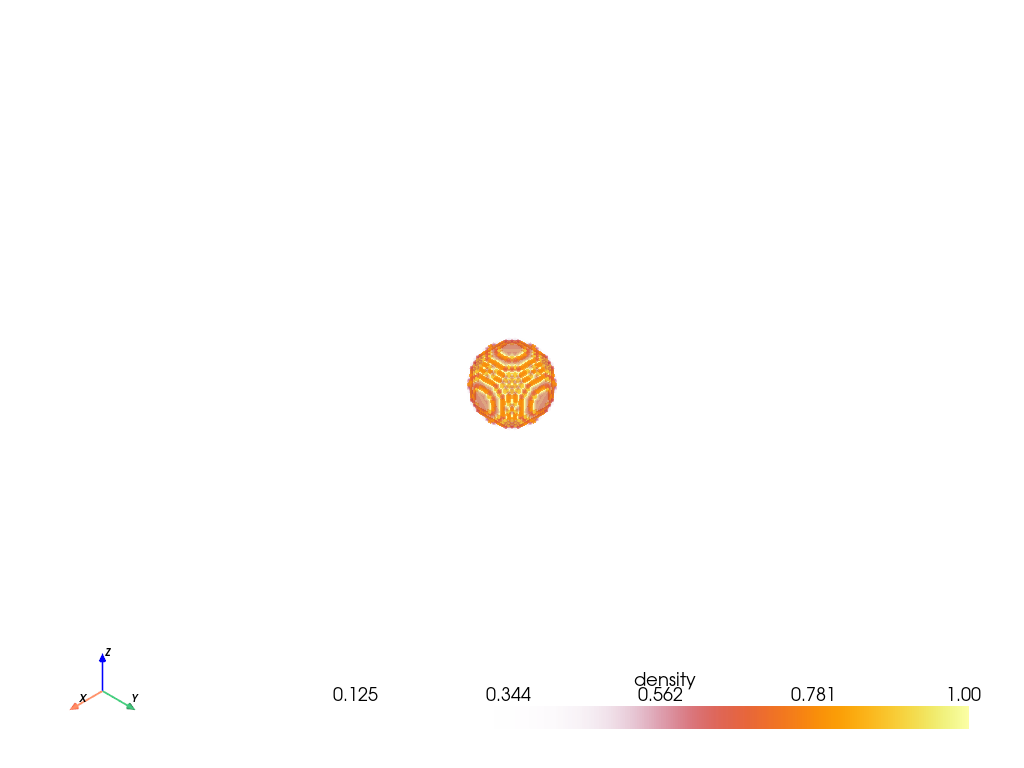

In [ ]:
grid = pv.ImageData()

# VTK 규칙: cell data → dimensions = cell + 1 (x, y, z 순서)
grid.dimensions = (NUM_CELLS_X + 1, NUM_CELLS_Y + 1, NUM_CELLS_Z + 1)
grid.spacing = (DX, DY, DZ)
grid.origin = (X_DOMAIN[0], Y_DOMAIN[0], Z_DOMAIN[0])

# CELL(Z, Y, X) -> VTK(X, Y, Z) 축 정렬
rho = CELL[1:-1, 1:-1, 1:-1, 0].cpu().numpy()
rho_vtk = np.transpose(rho, (2, 1, 0))
grid.cell_data["density"] = rho_vtk.flatten(order="F")

# plotter는 한 번만 생성
plotter = pv.Plotter(off_screen=True)
plotter.add_volume(grid, scalars="density", cmap="inferno", opacity="sigmoid")
plotter.add_axes()


t = T_DOMAIN[0]

while t < T_DOMAIN[1]:
    CELL, dt = update(CELL)
    t += dt

    rho = CELL[1:-1, 1:-1, 1:-1, 0].cpu().numpy()

    ho_vtk = np.transpose(rho, (2, 1, 0))
    grid.cell_data["density"][:] = rho_vtk.flatten(order="F")

    clear_output(wait=True)
    plotter.show(jupyter_backend="static")

In [28]:
'''
fig, ax = plt.subplots(figsize=(8, 8))

rho = CELL[1:-1, NUM_CELLS_Y // 2, 1:-1, 0].cpu().numpy()

im = ax.imshow(
    rho,
    origin='lower',
    extent=[X_DOMAIN[0], X_DOMAIN[1], Z_DOMAIN[0], Z_DOMAIN[1]],
    cmap='viridis'
)

ax.set_title('Density slice at y = ' + str(NUM_CELLS_Y // 2))
ax.set_xlabel('x')
ax.set_ylabel('z')
plt.colorbar(im, ax=ax)

t = T_DOMAIN[0]

while t < T_DOMAIN[1]:
    CELL, dt = update(CELL)
    t += dt

    # ❗ 반드시 같은 indexing 유지
    rho = CELL[1:-1, NUM_CELLS_Y // 2, 1:-1, 0].cpu().numpy()

    im.set_data(rho)    

    fig.suptitle(f't = {t:.3f}')

    clear_output(wait=True)
    display(fig)
'''

"\nfig, ax = plt.subplots(figsize=(8, 8))\n\nrho = CELL[1:-1, NUM_CELLS_Y // 2, 1:-1, 0].cpu().numpy()\n\nim = ax.imshow(\n    rho,\n    origin='lower',\n    extent=[X_DOMAIN[0], X_DOMAIN[1], Z_DOMAIN[0], Z_DOMAIN[1]],\n    cmap='viridis'\n)\n\nax.set_title('Density slice at y = ' + str(NUM_CELLS_Y // 2))\nax.set_xlabel('x')\nax.set_ylabel('z')\nplt.colorbar(im, ax=ax)\n\nt = T_DOMAIN[0]\n\nwhile t < T_DOMAIN[1]:\n    CELL, dt = update(CELL)\n    t += dt\n\n    # ❗ 반드시 같은 indexing 유지\n    rho = CELL[1:-1, NUM_CELLS_Y // 2, 1:-1, 0].cpu().numpy()\n\n    im.set_data(rho)    \n\n    fig.suptitle(f't = {t:.3f}')\n\n    clear_output(wait=True)\n    display(fig)\n"